In [1]:
######################################################
### Attaching and downloading necessary packagaes ####
######################################################
# if (!requireNamespace("BiocManager", quietly = FALSE))
#     install.packages("BiocManager")
# BiocManager::version()
# library("devtools")
# devtools::install_github("broadinstitute/infercnv", force=TRUE)
# detach("package:infercnv", unload=T)  ### package infercnv_1.15.3  seems to work fine
library(infercnv)
#### loading packages and others 
library("Seurat")
library("tidyverse")
#remotes::install_github("mojaveazure/seurat-disk")
library("SeuratDisk")
#install.packages("ggplot2")
library(ggplot2)
#install.packages("remotes")
#remotes::install_github("chris-mcginnis-ucsf/DoubletFinder", force=TRUE)
library(DoubletFinder)
library(dplyr)
library(tidyverse)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [3]:
library(DoubletFinder)

In [5]:
## Step 1 . Read a scRNA file 
dat <- Read10X_h5("/data/kumarr9/scRNA/RU426B_HTAN_MSK.h5")

## step 2 . creating seurat object with with desired cell and gene parameters and also name the project
dat_seurat_obj <- CreateSeuratObject(counts = dat, min.cells = 3, min.features = 200, project = 'SCLC')

## step 3 . Identifying mitochindrial contamination-- and adding it to seurat object -- use MT when human and mt when mouse
dat_seurat_obj[["percent.mt"]] <- PercentageFeatureSet(dat_seurat_obj, pattern = "^MT-")
#View(dat_seurat_obj@meta.data) ## to visualize the data to see mitochondrial cells contamination

## step 4. plotting the mitochondrial contamination or data distribution
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/data_features.jpg", width = 3000, height = 2000, res=300)
VlnPlot(dat_seurat_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
dev.off()

## step 5. viewing data distribution before mitochondrial contamination removal
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/data_distribution.jpg", width = 3000, height = 2000, res=300)
plot1 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
plot2 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
SCAF3163_features <- plot1 + plot2
SCAF3163_features
dev.off()

## step 6. Removing low quality cells and mitochondrial contamination
dat_seurat_obj_filtered <- subset(dat_seurat_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

### just to see what number of cells left after feature selection 
#dat_seurat_obj
#dat_seurat_obj_filtered

## step 7. plots the results after filtering or filtered features
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/data_filtered_features.jpg", width = 3000, height = 2000, res=300)
VlnPlot(dat_seurat_obj_filtered, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
dev.off()
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/data_distribution_filtered_features.jpg", width = 3000, height = 2000, res=300)
plot1 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
plot2 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
SCAF3163_features_filtered <- plot1 + plot2
SCAF3163_features_filtered
dev.off()
#### Before any kind of scRNA, need to do the Normalization ###
### After removing unwanted cells from the dataset, the next step is to normalize the data. I employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result

## step 8. Normalization of the data 
dat_seurat_obj_filtered <- NormalizeData(dat_seurat_obj_filtered)

## step 9. Identifying highly variable features from the normalized data 
## We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). 
## focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.
dat_seurat_obj_filtered <- FindVariableFeatures(dat_seurat_obj_filtered, selection.method = "vst")
# Identify the 10 most highly variable genes  (change to to your desired number of genes)
top10 <- head(VariableFeatures(dat_seurat_obj_filtered), 10)

# plot variable features with and without labels
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/most_variable.jpg", width = 3000, height = 2000, res=300)
plot1 <- VariableFeaturePlot(dat_seurat_obj_filtered)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
SCAF3163_filterd_variable <- plot1 + plot2
SCAF3163_filterd_variable
dev.off()
## step 10. scale the data, Regression should be done during scaling of the data 
#(Note - here, we can also, remove unwanted source of vaiation like mitochondrial cell or cell cycle etc., see vignettes for more details)
# Shifts the expression of each gene, so that the mean expression across cells is 0
#Scales the expression of each gene, so that the variance across cells is 1
#This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
#The results of this are stored in pbmc[["RNA"]]@scale.data
#############################################
### Parth ask to assign cell cycle score ####
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
dat_seurat_obj_filtered <- CellCycleScoring(dat_seurat_obj_filtered, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
### Regressing out cell cycle from the object ###
dat_seurat_obj_filtered$CC.Difference <- dat_seurat_obj_filtered$S.Score - dat_seurat_obj_filtered$G2M.Score
dat_seurat_obj_filtered <- ScaleData(dat_seurat_obj_filtered, vars.to.regress = "CC.Difference", features = rownames(dat_seurat_obj_filtered))
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/difference_regressed_cell_cyle_RU1138.jpg", width = 3000, height = 2000, res=300)
dat_seurat_obj_filtered <- RunPCA(dat_seurat_obj_filtered, features = c(s.genes, g2m.genes))
DimPlot(dat_seurat_obj_filtered)
dev.off()


## step 11. Run PCA to reduce the dimensionality
# By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset, like this pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
dat_seurat_obj_filtered <- RunPCA(object = dat_seurat_obj_filtered)
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/elbow.jpg", width = 3000, height = 2000, res=300)
ElbowPlot(dat_seurat_obj_filtered)
dev.off()
# Examine and visualize PCA results a few different ways
#print(dat_seurat_obj_filtered[["pca"]], dims = 1:5, nfeatures = 5)
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/PCA_plots_heterogeneity.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "pca")
dev.off()


Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of percent.mt."


png 
  2

Warning message in cor(x = data[, 1], y = data[, 2]):
"the standard deviation is zero"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of percent.mt."


png 
  2

Warning message in cor(x = data[, 1], y = data[, 2]):
"the standard deviation is zero"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"


png 
  2

Warning message:
"The following features are not present in the object: MLF1IP, not searching for symbol synonyms"
Regressing out CC.Difference

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 1 features requested have not been scaled (running reduction without them): MLF1IP"
Warning message in irlba(A = t(x = object), nv = npcs, ...):
"You're computing too large a percentage of total singular values, use a standard svd instead."
PC_ 1 
Positive:  HN1, CTCF, NCAPD2, G2E3, CDC25C, RPA2, LBR, MCM6, CKAP2, CDCA7 
	   BLM, MCM5, TUBB4B, CKAP5, TIPIN, RANGAP1, CASP8AP2, POLD3, SLBP, UBR7 
	   TACC3, ANP32E, CHAF1B, KIF20B, GAS2L3, EXO1, DSCC1, CDC45, HMMR, HMGB2 
Negative:  BIRC5, TOP2A, TPX2, NUSAP1, NEK2, TYMS, NUF2, CDK1, CLSPN, CENPF 
	   UBE2C, MKI67, CDCA3, RAD51AP1, RRM2, GMNN, KIF11, ECT2, CCNB2, FEN1 
	   PCNA, GINS2, MCM4, USP1, DLGAP5, KIF23, CKS1B, WDR76, CDCA2, ATAD2 
PC_ 2 
Positive:  NEK2, D

png 
  2

PC_ 1 
Positive:  SOX4, TUBB2B, EPCAM, BEX1, BEX3, HES6, IFI27, IGFBP5, ASCL1, STMN1 
	   IGFBP2, GRP, PCSK1N, CD24, MARCKSL1, CKB, KRT8, SPINT2, NR2F1, RBP1 
	   TFF3, MAP1B, PEG10, MARCKS, CDKN2A, SYT1, WFDC2, KRT18, ID4, HSPB1 
Negative:  PTPRC, SRGN, HCST, CXCR4, TSC22D3, ARHGDIB, CYTIP, TNFAIP3, SYTL3, CD69 
	   DUSP2, CD52, CCL5, RGS1, ACAP1, ETS1, SLA, CD7, GZMA, CST7 
	   CD2, LCP1, HLA-E, SAMSN1, ZFP36L2, TRBC1, STK17B, GMFG, CD3E, CORO1A 
PC_ 2 
Positive:  PCSK1N, BEX1, HES6, SEC11C, CDKN2A, TUBB2B, EPCAM, BEX2, CD24, ASCL1 
	   STMN1, TSTD1, PEG10, SYT1, TFF3, TAGLN3, CKB, WFDC2, PCP4, SCG2 
	   OCIAD2, HMGN2, UBE2S, H2AFV, PSIP1, H1FX, HMGB2, COTL1, SRP9, HMGN1 
Negative:  SPARC, SERPING1, CALD1, IGFBP7, NNMT, BGN, MGP, A2M, COL4A2, COL6A2 
	   CAV1, C1S, FSTL1, COL6A1, C1R, PMP22, SPARCL1, LUM, TIMP3, IGFBP4 
	   TPM2, TGM2, AEBP1, PTRF, DCN, COL4A1, VCAN, COL3A1, COL1A2, COL5A2 
PC_ 3 
Positive:  RNASE1, PECAM1, CDH5, AQP1, THBD, CLEC14A, RAMP3, CALCRL, SLCO2A1, FLT1 
	  

png 
  2

png 
  2

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 913
Number of edges: 27830

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9571
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 913
Number of edges: 27830

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8979
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 913
Number of edges: 27830

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8626
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 913
Number of edges: 27830

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8395
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer versi

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.0.1,RNA_snn_res.0.3,RNA_snn_res.0.5,RNA_snn_res.0.7,RNA_snn_res.0.9,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
RU426B_240153832077219,RU426B,12359.022,1300,0,-0.012720300,-0.052182984,G1,RU426B,0.039462684,1,1,5,5,6,6,6
RU426B_226394650073397,RU426B,20350.459,2363,0,-0.138806715,-0.183726600,G1,RU426B,0.044919885,3,4,6,6,7,7,7
RU426B_130693100099829,RU426B,4103.474,359,0,-0.076523130,-0.046760732,G1,RU426B,-0.029762398,5,6,9,9,10,10,10
RU426B_157606888291043,RU426B,21185.087,2472,0,0.020020895,-0.149497675,S,RU426B,0.169518571,0,0,0,1,0,0,0
RU426B_169707671509724,RU426B,7889.809,764,0,-0.141022916,-0.083464968,G1,RU426B,-0.057557948,2,3,4,4,3,3,3
RU426B_135622024096044,RU426B,11515.847,1194,0,-0.118446753,0.410437332,G2M,RU426B,-0.528884085,0,2,7,7,8,8,8
RU426B_201587038305118,RU426B,7570.445,728,0,0.089141291,-0.106011572,S,RU426B,0.195152862,0,2,2,0,4,4,4
RU426B_134395511622388,RU426B,7888.540,769,0,-0.080557915,-0.160946325,G1,RU426B,0.080388410,3,4,6,6,7,7,7
RU426B_191141961193331,RU426B,13221.744,1402,0,0.268098213,0.478361739,G2M,RU426B,-0.210263526,0,0,3,3,2,2,2


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
18:20:19 UMAP embedding parameters a = 0.9922 b = 1.112

18:20:19 Read 913 rows and found 20 numeric columns

18:20:19 Using Annoy for neighbor search, n_neighbors = 30

18:20:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:20:19 Writing NN index file to temp file /lscratch/3225750/RtmpSEBxBI/fileb21ba9f0ad3

18:20:19 Searching Annoy index using 1 thread, search_k = 3000

18:20:19 Annoy recall = 100%

18:20:20 Commencing smooth kNN distance calibration using 1 thread
 with target n_

png 
  2

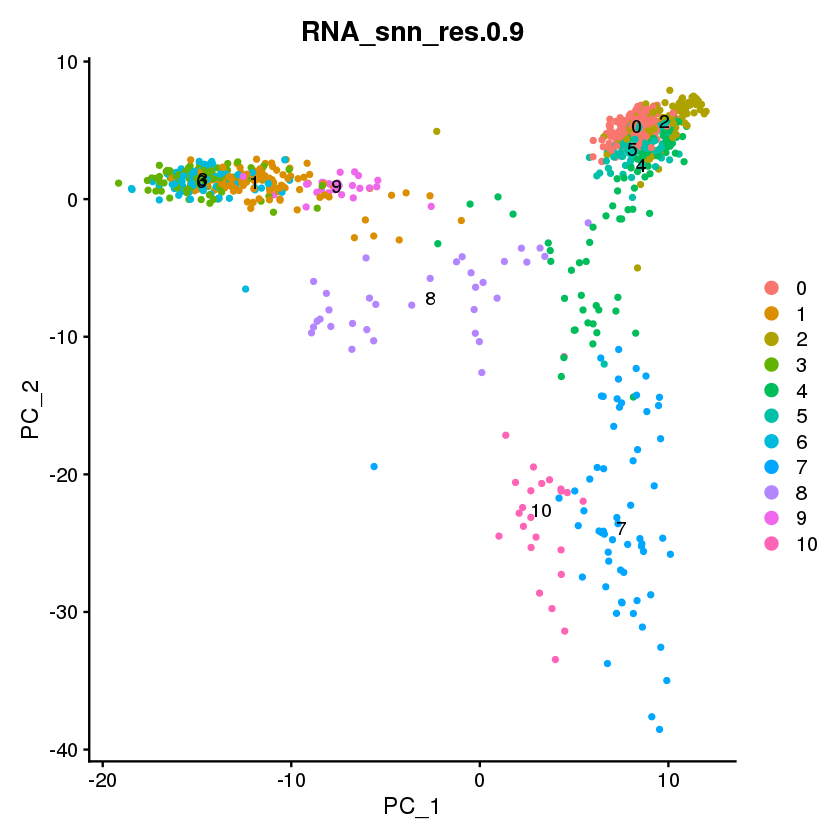

In [6]:
## step 12. clusters the cells 
# Now using the elbow method we determine the neighbours, make the clusters of neighbour and then ran the UMAP to plot the same
dat_seurat_obj_filtered <- FindNeighbors(dat_seurat_obj_filtered, dims = 1:20) ## can change dims according to your needs
dat_seurat_obj_filtered <- FindClusters(dat_seurat_obj_filtered, resolution=c(0.1, 0.3, 0.5, 0.7, 0.9, 1)) ### here resolution (resolution = 0.5 or so) or like this wasy (resoultion=c(0.1, 0.3, 0.5, 0.7, 1)) can be added to see at what resolution your data fits ( resolution here means, how many clusters you want to see in your data, lower the number lower cluster anf higher the number higher clusters)
View(dat_seurat_obj_filtered@meta.data)
#DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.1", label=TRUE)
DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.9", label=TRUE)
# DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.7", label=TRUE)
# DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.5", label=TRUE)
# optional step (to set the granularity of the data, i mean the number of clusters to be shown in UMAP)
## seeing or setting identity of clusters  
## Idents function store the identity of cluster
#head(Idents(dat_seurat_obj_filtered), 5) 
#Idents(dat_seurat_obj_filtered)
# when want to set the identity 
#Idents(dat_seurat_obj_filtered) <- SCLC_snn_res_0.3 ## this will set the resolution at 0.3 and make the only number of clusters which are in 0.3 resolution

## choosing best cluster using Dimplot, as above
Idents(dat_seurat_obj_filtered) <- "RNA_snn_res.0.9" ## setting increased resolution of cluster 
dat_seurat_obj_filtered <- RunUMAP(dat_seurat_obj_filtered, dims = 1:20)
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/UMAP.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE)
dev.off()

png 
  2

png 
  2

Loading required package: fields

Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite


Try help(fields) to get started.



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR



NULL


png 
  2

[1] "Creating 304 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.0.1,RNA_snn_res.0.3,RNA_snn_res.0.5,RNA_snn_res.0.7,RNA_snn_res.0.9,RNA_snn_res.1,seurat_clusters,pANN_0.25_0.03_61,DF.classifications_0.25_0.03_61
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>
RU426B_240153832077219,RU426B,12359.022,1300,0,-0.012720300,-0.052182984,G1,RU426B,0.039462684,1,1,5,5,6,6,6,0.00000000,Singlet
RU426B_226394650073397,RU426B,20350.459,2363,0,-0.138806715,-0.183726600,G1,RU426B,0.044919885,3,4,6,6,7,7,7,0.24324324,Singlet
RU426B_130693100099829,RU426B,4103.474,359,0,-0.076523130,-0.046760732,G1,RU426B,-0.029762398,5,6,9,9,10,10,10,0.00000000,Singlet
RU426B_157606888291043,RU426B,21185.087,2472,0,0.020020895,-0.149497675,S,RU426B,0.169518571,0,0,0,1,0,0,0,0.08108108,Singlet
RU426B_169707671509724,RU426B,7889.809,764,0,-0.141022916,-0.083464968,G1,RU426B,-0.057557948,2,3,4,4,3,3,3,0.05405405,Singlet
RU426B_135622024096044,RU426B,11515.847,1194,0,-0.118446753,0.410437332,G2M,RU426B,-0.528884085,0,2,7,7,8,8,8,0.02702703,Singlet
RU426B_201587038305118,RU426B,7570.445,728,0,0.089141291,-0.106011572,S,RU426B,0.195152862,0,2,2,0,4,4,4,0.08108108,Singlet
RU426B_134395511622388,RU426B,7888.540,769,0,-0.080557915,-0.160946325,G1,RU426B,0.080388410,3,4,6,6,7,7,7,0.13513514,Singlet
RU426B_191141961193331,RU426B,13221.744,1402,0,0.268098213,0.478361739,G2M,RU426B,-0.210263526,0,0,3,3,2,2,2,0.05405405,Singlet


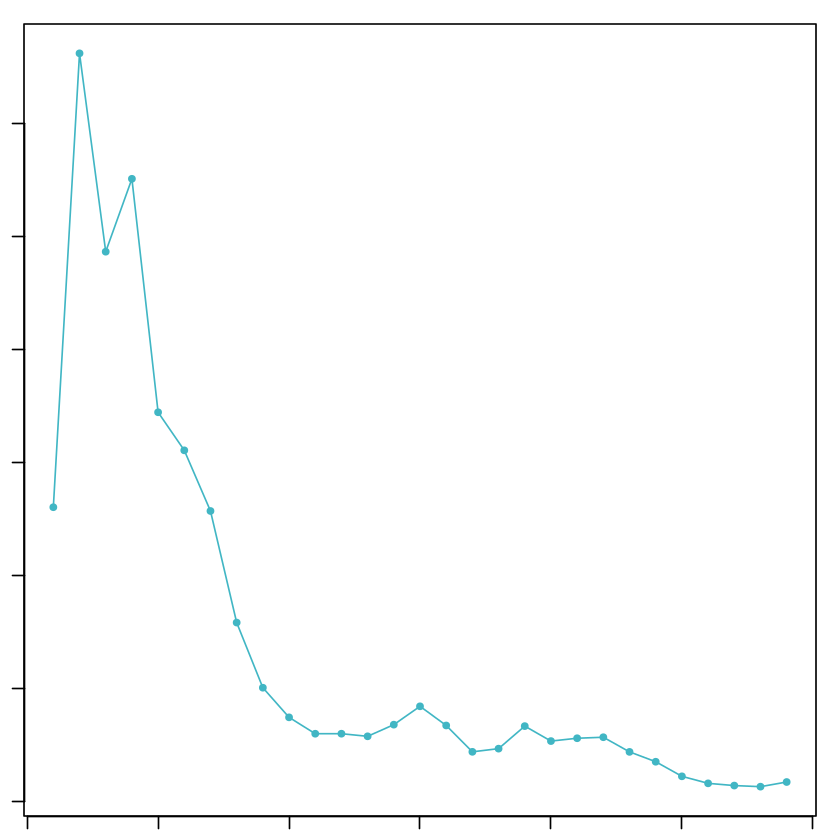

In [7]:
# Plotting for cell cycle scores
##### seeing the object formed for cell cycle scores ####
#head(dat_seurat_obj_filtered[[]])
#str(dat_seurat_obj_filtered)
#Getting Cell cycle scores from the seurat object 
S_score <- dat_seurat_obj_filtered@meta.data$S.Score
g2m_score <- dat_seurat_obj_filtered@meta.data$G2M.Score
cluster_info <- as.numeric(as.character(dat_seurat_obj_filtered@meta.data$seurat_clusters))
Phase <- dat_seurat_obj_filtered@meta.data$Phase
# View(S_score)
# View(g2m_score)
# View(cluster_info)
# View(Phase)
# making dataframe by combining relative stuff what we want to show in plot
cell_df <- cbind(cluster_info, Phase, g2m_score, S_score)

## converting to dataframe and calculating the percentage for stacked bar plot 
# link - https://rpubs.com/techanswers88/stackedbarcharts
cell_df <- data.frame(cell_df)
dt <- cell_df%>%
  dplyr::group_by(cluster_info, Phase)%>%
  dplyr::tally()%>%
  dplyr::mutate(percent=n/sum(n))

## plotting the result 
# pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
# pl <- pl + geom_bar(stat="identity")
# pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
#                      position=position_stack(vjust=0.5), colour="white", size = 2)


# pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 ))
# pl
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/cell_cycle.jpg", width = 2000, height = 1200, res=300)
pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
pl <- pl + geom_bar(stat="identity", position ="fill")
pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
                     position=position_fill(vjust=0.5), colour="black", size =3)

pl <- pl + theme_minimal()
#pl <- pl + labs(title ="Cell cycle score for SCAF2229")
#pl <- pl + labs(subtitle ="plot")
pl <- pl + labs(caption ="Cell cycle score for RU426B")
pl <- pl  + labs(x ="Cluster", y = "Percentage")
pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 )) + coord_flip()
pl
dev.off()

### cell cycle plot without percent label
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/cell_cycle_RU426B.jpg", width = 2000, height = 1200, res=300)
ggplot(dt, aes(x = cluster_info, y = percent, fill = Phase))+
  geom_col()
dev.off()
### we finished with data pre-processing prior to any doublet finder --- Now we can go for doublet finder 
### Important points - 1. Doublet finder needs to be done on each sample separately, prior to aggregating 
## pk identification --- no ground truth approach
# link -- https://rdrr.io/github/chris-mcginnis-ucsf/DoubletFinder/man/doubletFinder_ParamSweep.html
# link - https://www.youtube.com/watch?v=NqvAS4HgmrE
## required packages 
#install.packages("remotes")
#remotes::install_github("chris-mcginnis-ucsf/DoubletFinder", force=TRUE)
#library(DoubletFinder)

## step 13. Doublet Finding
sweep.list_SCAF3163 <- paramSweep_v3(dat_seurat_obj_filtered, PCs =1:20, sct=FALSE)
sweep.stats_SCAF3163 <- summarizeSweep(sweep.list_SCAF3163, GT = FALSE)
bcmvn_SCAF3163 <- find.pK(sweep.stats_SCAF3163)

### plotting the results --- highest value in plot is your optimal pK
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/optimal_k.jpg", width = 3000, height = 2000, res=300)
ggplot(bcmvn_SCAF3163, aes(pK, BCmetric, group=1))+
geom_point()+
geom_line()
dev.off()


### storing the highest pk value to a pk variable
pK <- bcmvn_SCAF3163 %>%
      filter(BCmetric == max(BCmetric)) %>%
      select(pK)
pK <- as.numeric(as.character(pK[[1]]))


### Homotypic doublet proprotion estimation
annotations <- dat_seurat_obj_filtered@meta.data$seurat_clusters
homotypic.prop <- modelHomotypic(annotations)
nExp_poi <- round(0.076*nrow(dat_seurat_obj_filtered@meta.data))
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))


#### run Doubletfinder 
dat_seurat_obj_filtered <- doubletFinder_v3(dat_seurat_obj_filtered, PCs = 1:20, pN = 0.25, pK = pK, nExp = nExp_poi.adj, reuse.pANN = FALSE, sct = FALSE)
## Viewing data frame 
View(dat_seurat_obj_filtered@meta.data)

In [8]:
# before plotting we need to see following items in our data
names(dat_seurat_obj_filtered@meta.data)
# from there we got the DF.classification, which we need for plot
# homotypic.prop
nExp_poi ## number of expected doublets
nExp_poi.adj ## number of actual doublets

[1] "orig.ident"                      "nCount_RNA"                     
 [3] "nFeature_RNA"                    "percent.mt"                     
 [5] "S.Score"                         "G2M.Score"                      
 [7] "Phase"                           "old.ident"                      
 [9] "CC.Difference"                   "RNA_snn_res.0.1"                
[11] "RNA_snn_res.0.3"                 "RNA_snn_res.0.5"                
[13] "RNA_snn_res.0.7"                 "RNA_snn_res.0.9"                
[15] "RNA_snn_res.1"                   "seurat_clusters"                
[17] "pANN_0.25_0.03_61"               "DF.classifications_0.25_0.03_61"

[1] 69

[1] 61

In [9]:
### visulaize the doublets 
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/doublets.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.03_61")
dev.off()

## Step 13. Doublets removal
#since we have the name doublets in one of our meta data column of a "dat_seurat_obj_filtered@meta_data", this column has singlet and doublet information
#we can only select singlet by specifying values and so
#Link --- https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/seurat/seurat_01_qc.html
#data.filt = data.filt[, data.filt@meta.data[, DF.name] == "Singlet"]
data.filt = dat_seurat_obj_filtered[, dat_seurat_obj_filtered@meta.data[, "DF.classifications_0.25_0.03_61"] == "Singlet"]
#dim(data.filt)

### ploting the doublet removed dataset for PC & UMAP
#png("/data/kumarr9/scRNA/scRNA_results/SCAF3163/UMAP_doublets_removed.jpg", width = 3000, height = 2000, res=300)
#DimPlot(data.filt, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.01_287")
#dev.off()


### plotting the doublet removed dataset with cluster info 
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/without_doublets.jpg", width = 3000, height = 2000, res=300)
DimPlot(data.filt, reduction = "umap", label = TRUE)
dev.off()


## step 14. Finding differentially expressed features (cluster biomarkers)
# find markers for every cluster compared to all remaining cells, report only the positive ones
dat_filt.markers <- FindAllMarkers(data.filt, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
dat_filt.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)
# saving all the markers genes
write.csv(dat_filt.markers, file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/positive_marker_gene.csv")
# saving markers genes for a defined crieria
sub_df <- subset(dat_filt.markers, avg_log2FC > 2 & p_val < 0.05)
write.csv(sub_df, file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/positive_marker_gene_significant.csv")
# plotting the marker gene 
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/top5_markers.jpg", width = 5500, height = 3300, res=300)
dat_filt.markers %>%
    group_by(cluster) %>%
    top_n(n = 5, wt = avg_log2FC) -> top5
DoHeatmap(data.filt, features = top5$gene) + NoLegend()
dev.off()


png 
  2

png 
  2

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
9.118149e-56,1.482958,0.503,0.039,1.652026e-51,0,DLL3
1.392653e-55,1.417587,0.703,0.102,2.523209e-51,0,SCG2
5.340838e-72,2.289791,0.813,0.093,9.676530e-68,1,IL7R
7.469739e-77,2.271161,0.888,0.103,1.353367e-72,1,CD3D
3.201137e-53,1.935281,0.578,0.062,5.799820e-49,2,UBE2T
1.582968e-62,1.916698,0.477,0.019,2.868022e-58,2,ZWINT
9.861223e-126,2.842516,0.737,0.005,1.786656e-121,3,KLRC1
1.522852e-113,2.742433,0.899,0.045,2.759103e-109,3,KLRB1
4.166281e-05,1.903153,0.389,0.281,7.548468e-01,4,TFF3


png 
  2

Welcome to the CytoTRACE R package, a tool for the unbiased prediction of differentiation states in scRNA-seq data. For more information about this method, visit https://cytotrace.stanford.edu.


Warning message:
"The ScanoramaCT python module is not accessible. The iCytoTRACE function for integration across multiple datasets will be disabled. Please follow the instructions in https://github.com/gunsagargulati/CytoTRACE to install the necessary Python packages for this application."
Warning message:
"The following arguments are not used: scale.factor"
Centering and scaling data matrix

The number of cells in your dataset is less than 3,000. Fast mode has been disabled.

CytoTRACE will be run on 1 sub-sample(s) of approximately 852 cells each using 1 / 1 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done

Warning message:
"Inva

png 
  2

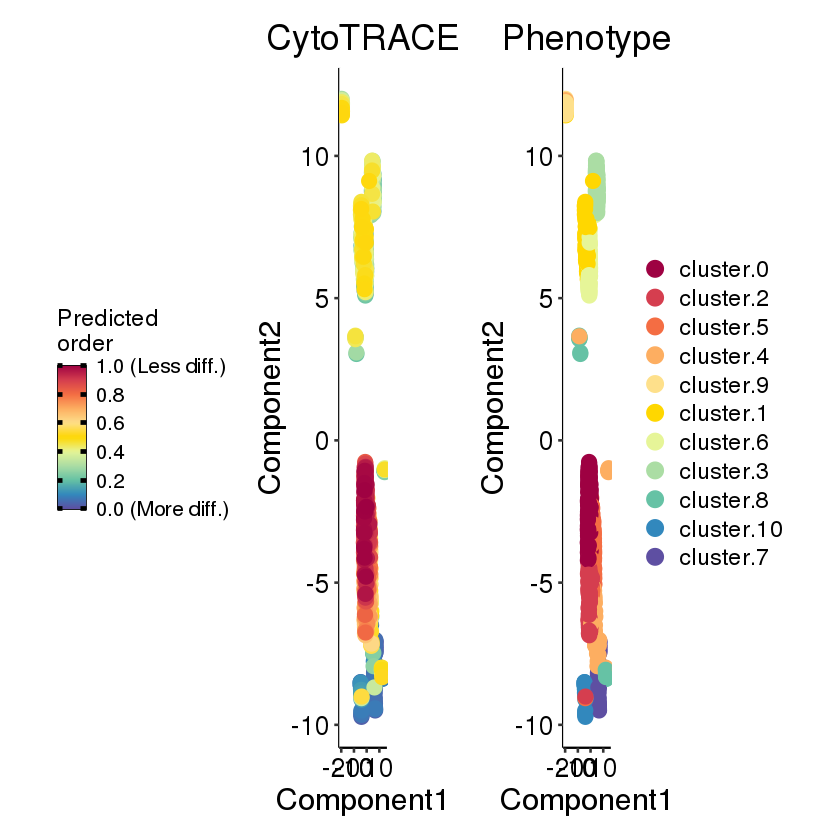

In [10]:
#### Cyotrace analysis starts from here ####
# Link - https://cytotrace.stanford.edu/
####
#install.packages("devtools")
#devtools::install_local("/data/kumarr9/CytoTRACE_0.3.3.tar.gz")
library(CytoTRACE)
#### Cyotrace needs the normalized seurat object
# mtrx should be non-negative(?) => seurat_obj should be normalized using scale.factor=1e6 instead of default (1e5)
seurat_obj <- ScaleData(data.filt, scale.factor=1e6 )
# seurat_obj <- RunPCA(seurat_obj)
# seurat_obj <- JackStraw(seurat_obj)
# seurat_obj <- ScoreJackStraw(seurat_obj)
# seurat_obj <- FindClusters(seurat_obj)
mtrx <- FetchData(seurat_obj, vars=rownames(seurat_obj))
mtrx <- t(mtrx)
## remove genes with 0 reads (of the genes included)
 genes.w.reads <- names(rowSums(mtrx)[rowSums(mtrx)>0])
 mtrx <- mtrx[genes.w.reads,]

 mtrx <- data.frame(mtrx)
 mtrx[mtrx=='.'] <- 0

# ##  outputs a list that includes CytoTRACE score per cell
 Cytotrace.out <- CytoTRACE(mtrx)

 meta <- paste0('cluster.', seurat_obj$seurat_clusters)
 names(meta) <- colnames(seurat_obj)
 names(meta) <- str_replace(names(meta), '-', '.')

# ## UMAP embeddings from Seurat
 umap.embeddings <- as.data.frame(seurat_obj[["umap"]]@cell.embeddings)
 row.names(umap.embeddings) <- str_replace(row.names(umap.embeddings), '-', '.')

 cytotrace.plots <- plotCytoTRACE(Cytotrace.out, emb = umap.embeddings, phenotype = meta, outputDir = '/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/CytoTRACE.output.data')
#### Getting NE, Non-NE gene expression within each cluster of seurat object ####

# Provide a list of genes whose expression you want to see within each cluster
sclc_ne_genes <- c("ASCL1", "BEX1", "BSN", "CELF3", "CHGA", "CHGB","CRMP1", "FAM57B", "INSM1", "KIF1A", 
                   "KIF5C", "MYT1", "RTN1", "RUNDC3A", "SCG3","SEZ6", "SH3GL2", "SYN1", "SYP", "SYT11", 
                    "SYT4", "TAGLN3" ,"TFF3", "TMSB15A", "TMSB15B")
sclc_non_ne_genes <- c("ABCC3", "AHNAK", "ANXA1", "ARHGDIB", "CAV1","CAV2", "CCND1", "CYR61", "EMP1", "EPHA2",
                        "IFITM2", "IFITM3", "ITGB4", "LGALS3", "MYOF","PLAU", "PTGES", "RAB27B", "S100A10", "S100A16",
                        "SLC16A5", "TACSTD2", "TGFBI", "TGFBR2", "YAP1")

# Use the marker genes for each cluster identified in previous steps -
#dat_filt.markers <- FindAllMarkers(data.filt, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

seurat_obj <- AddModuleScore(object = seurat_obj, 
                                   features = list(sclc_ne_genes),
                                   ctrl = 20,
                                   name = "NE_genes_expression"
                                   )

seurat_obj <- AddModuleScore(object = seurat_obj, 
                                   features = list(sclc_non_ne_genes),
                                   ctrl = 20,
                                   name = "Non-NE_gene_expression"
                                   )
#Getting NE expression data
gene_data <- seurat_obj@meta.data$NE_genes_expression1
cluster_info <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info <- as.numeric(cluster_info)
data_df <- cbind(gene_data, cluster_info)
data_df <- as.data.frame(data_df)
#data_df <- data.frame(gene_data, cluster_info)
# Set the plot title and y-axis label
plot_title <- "NE gene expression"
y_axis_label <- "Expression"

# Create the violin/box plot
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/NE_NonNE.jpg", width = 3000, height = 1500, res=300)
library(ggplot2)
ne <- ggplot(data_df, aes(x = factor(cluster_info), y = gene_data, col = factor(cluster_info)), add = "jitter") + 
  geom_boxplot(scale = "width") +
  ggtitle(plot_title) + 
  xlab("Cluster") + theme_classic() +
  ylab(y_axis_label) + geom_hline(yintercept=0.00, linetype="dashed", color = "red")

#png("/data/kumarr9/scRNA/scRNA_results/SCAF3163/NE.jpg", width = 3000, height = 2000, res=300)

#Getting Non_NE expression data
gene_data2 <- seurat_obj@meta.data$Non.NE_gene_expression1
cluster_info2 <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info2 <- as.numeric(cluster_info2)
data_df2 <- cbind(gene_data2, cluster_info2)
data_df2 <- as.data.frame(data_df2)
#data_d2f <- data.frame(gene_data2, cluster_info2)
# Set the plot title and y-axis label
plot_title2 <- "Non_NE gene expression"
y_axis_label <- "Expression"
# Create the violin/box plot
non_ne <- ggplot(data_df2, aes(x = factor(cluster_info2), y = gene_data2, col = factor(cluster_info2)), add = "jitter") + 
  geom_boxplot(scale = "width") +
  ggtitle(plot_title2) + 
  xlab("Cluster") + theme_classic() +
  ylab(y_axis_label) + geom_hline(yintercept=0.00, linetype="dashed", color = "red")

NE_NonNE <- ne + non_ne
NE_NonNE
dev.off()

In [11]:
saveRDS(seurat_obj, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/RU426B_cell_cycle_regress_difference_out_resolution_0.9.rds")

In [12]:
####################################################################
#### Working with saved object to create InferCNV plots and so #####
####################################################################

#### trying working with seurat object ---
## trying InferCNV from the saved .rds file
RU426B <- readRDS("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/RU426B_cell_cycle_regress_difference_out_resolution_0.9.rds")
load("/data/kumarr9/scRNA/PBMC_seu.RData")

## step 16. mergind the two seurat object 
# link - https://satijalab.org/seurat/articles/merge_vignette.html
# We are merging based on normalized one and hence added the parameters of merge.data=TRUE
RU426B_merged <- merge(RU426B, y = PBMC_seu, add.cell.ids = c("SCLC", "PBMC"), project = "SCLC",
     merge.data = TRUE)
# to see the content of merged object
# SCAF3163_merged@assays$RNA@counts
# dim(SCAF3163_merged)
# dim(SCAF3163)
# dim(PBMC_seu)

## step 17. Getting count matrix from merged dataframe
#str(SCAF3163_merged)
expr_matrix <- GetAssayData(object = RU426B_merged, slot = "counts", assay = "RNA")
# converting the expr_matrix which is dgCmatrix to dataframe 
expr_df <- as.data.frame(expr_matrix)
#expr_df[1:20, 1:20]
write.table(expr_df, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/SCAF_matrix_0.9.csv", sep = "\t", row.names = TRUE, col.names = TRUE)
### creating gene order matrix for infercnv 
gene_names <- rownames(RU426B_merged)
### converted it to dataframe 
gene_names <- data.frame(gene_names)
## adding chromosme number, start and end to it
## read a gtf file ----
gtf_file <- read.table("/data/SCLCgenomics/rajesh/gene_version_27_cp.gtf")
matching_rows <- gtf_file[gtf_file$V5 %in% gene_names$gene_names, ]
### correcting this dataframe as given in inferCNV package
gene_df <- matching_rows %>% 
  select(V5, everything())
gene_df <- gene_df[, -5]
gene_df = gene_df[!duplicated(gene_df$V5),]
# names(gene_df)[2] <- "chr"
# names(gene_df)[3] <- "start"
# names(gene_df)[4] <- "stop"

###
write.table(gene_df, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/gene_order_0.9.txt", sep = "\t", row.names = FALSE, col.names = FALSE)
## getting the cluster info from the seurat object/merged object
clust_info <- RU426B_merged@meta.data[, "seurat_clusters", drop=F]
## making dataset what looks like or needed by the inferCNV
clust_info$cellID <- rownames(clust_info)
clust_info$clstr <- paste0('cluster.', clust_info$seurat_clusters)
clust_info_df <- clust_info[, !names(clust_info) %in% "seurat_clusters"]
write.table(clust_info_df, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/annotation_0.9.txt", sep = "\t", row.names = FALSE, col.names = FALSE)



Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


In [ ]:
# creating infercnv object
## Modification you need to do before creating object --
#1. Open the annotation.txt file and replace the PBMC cluster with PBMC only 
RU426B_infercnv_obj = CreateInfercnvObject(raw_counts_matrix="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/SCAF_matrix_0.9.csv",
                                    annotations_file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/annotation_0.9.txt",
                                    gene_order_file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/gene_order_0.9.txt",
                                    ref_group_names=c("PBMC"))

# perform infercnv operations to reveal cnv signal
infercnv_obj1 = infercnv::run(RU426B_infercnv_obj,
                             cutoff=0.1,  # use 1 for smart-seq, 0.1 for 10x-genomics
                             out_dir="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/infercnv_results_0.9",  # dir is auto-created for storing outputs
                             cluster_by_groups=T,   # cluster
                             denoise=T,
                             HMM=T
                             )

INFO [2023-06-05 14:46:51] Parsing matrix: /data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/SCAF_matrix_0.9.csv
INFO [2023-06-05 14:47:58] Parsing gene order file: /data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/gene_order_0.9.txt
INFO [2023-06-05 14:47:58] Parsing cell annotations file: /data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/annotation_0.9.txt
INFO [2023-06-05 14:47:58] ::order_reduce:Start.
INFO [2023-06-05 14:47:59] .order_reduce(): expr and order match.
INFO [2023-06-05 14:48:01] ::process_data:order_reduce:Reduction from positional data, new dimensions (r,c) = 60554,4224 Total=22653901.5366144 Min=0 Max=3089.
INFO [2023-06-05 14:48:03] num genes removed taking into account provided gene ordering list: 6926 = 11.43772500578% removed.
INFO [2023-06-05 14:48:04] -filtering out cells < 100 or > Inf, removing 0 % of cells
WARN [2023-06-05 14:48:06] Please use "options(scipen = 100)" before running inf

Centering and scaling data matrix

PC_ 1 
Positive:  SNX2, CSNK1G3, SNCAIP, ZNF608, SRFBP1, AC113398.1, ALDH7A1, HSD17B4, PHAX, PRTFDC1 
	   OTUD1, LMNB1, ARHGAP21, MSRB2, GAD2, TNFAIP8, APBB1IP, PIP4K2A, ABI1, BMI1 
	   MARCH3, ANKRD26, COMMD3, DMXL1, PRRC1, YME1L1, DNAJC1, COMMD10, ACBD5, MLLT10 
Negative:  TADA2B, GRPEL1, TBC1D14, KIAA0232, BLOC1S4, WDR1, MRFAP1L1, ZNF518B, RAB28, BOD1L1 
	   MRFAP1, FBXL5, FAM200B, FGFBP2, CRMP1, TAPT1, QDPR, STX18, MANBA, UBE2D3 
	   LAP3, NFKB1, MED28, BANK1, HGNC:18790, CISD2, PPP3CA, BDH2, FAM184B, LYAR 
PC_ 2 
Positive:  RIF1, ARL5A, RND3, NMI, MMADHC, PRPF40A, ARL6IP6, KIF5C, RPRM, NR4A2 
	   CYTIP, EPC2, DAPL1, WDSUB1, MBD5, BAZ2B, MARCH7, CD302, ORC4, RBMS1 
	   ACVR2A, TANK, ZEB2, PSMD14, ARHGAP15, IFIH1, SPOPL, GCA, CXCR4, DARS 
Negative:  U2SURP, AC021074.1, CHST2, PLS1, PLSCR1, ATR, GYG1, XRN1, HLTF, GK5 
	   TFDP2, HPS3, ATP1B3, TM4SF1, RNF7, COMMD2, RASA2, RNF13, ZBTB38, PFN2 
	   TSC22D2, SERP1, SLC25A36, EIF2A, MBNL1, SELENOT, GPR17

INFO [2023-06-05 14:56:35] define_signif_tumor_subclusters(), tumor: cluster.1


Centering and scaling data matrix

PC_ 1 
Positive:  RHOA, TCTA, APEH, GPX1, IP6K1, USP4, QARS, QRICH1, NDUFAF3, IMPDH2 
	   UBA7, DALRD3, WDR6, RBM6, P4HTM, RBM5, ARIH2, GNAI2, PRKAR2A, IFRD2 
	   IP6K2, UQCRC1, HYAL2, SHISA5, TUSC2, RERE, ENO1, PARK7, TMA7, PER3 
Negative:  PPAT, PAICS, AASDH, SRP72, HOPX, CEP135, REST, EXOC1, NOA1, CLOCK 
	   POLR2B, IGFBP7, TMEM165, CENPC, SRD5A3, CHIC2, UBA6, FIP1L1, YTHDC1, DANCR 
	   JCHAIN, USP46, UTP3, SGCB, RUFY3, DCUN1D4, GRSF1, OCIAD2, DCK, ANKRD17 
PC_ 2 
Positive:  GINM1, KATNA1, PPIL4, LATS1, TAB2, PCMT1, LRP11, STXBP5, AKAP12, RMND1 
	   RAB32, ARMT1, SHPRH, SYNE1, UTRN, FBXO5, STX11, MTRF1L, SF3B5, RGS17 
	   LTV1, AL590867.2, PHACTR2, IPCEF1, FUCA2, CNKSR3, PEX3, ADAT2, AIG1, SCAF8 
Negative:  SEC24B, MCUB, OSTC, CASP6, RPL34, PLA2G12A, GAR1, LEF1, AP1AR, HADH 
	   TIFA, PAPSS1, LARP7, AIMP1, TBCK, ANK2, NPNT, INTS12, AC004057.1, PPA2 
	   TET2, CXXC4, BDH2, CAMK2D, CISD2, UBE2D3, MANBA, SNHG8, NFKB1, BANK1 
PC_ 3 
Positive:  MYD88, O

INFO [2023-06-05 14:56:35] define_signif_tumor_subclusters(), tumor: cluster.10


Centering and scaling data matrix

PC_ 1 
Positive:  TPX2, BCL2L1, PDRG1, HCK, ID1, TM9SF4, HM13, KIF3B, ABHD12, ASXL1 
	   PYGB, NOL4L, COMMD7, ENTPD6, MAPRE1, CDK5RAP1, CBFA2T2, ACSS1, E2F1, CHMP4B 
	   APMAP, RALY, CST7, EIF2S2, CST3, NAPB, AHCY, NXT1, CD93, ITCH 
Negative:  COMMD9, TRIM44, API5, FJX1, TTC17, CD44, HSD17B12, PDHX, ALKBH3, APIP 
	   EHF, CAT, CAPRIN1, FBXO3, CD59, HIPK3, CSTF3, QSER1, PRRG4, EIF3M 
	   RCN1, IMMP1L, DNAJC24, ARL14EP, METTL15, LIN7C, CCDC34, SVIP, ADAM9, GOLGA7 
PC_ 2 
Positive:  PNO1, C1D, PPP3R1, ACTR2, CEP68, RAB1A, SERTAD2, PLEK, AFTPH, ARHGAP25 
	   PELI1, GFPT1, VPS54, NFU1, UGP2, AAK1, ANXA4, MDH1, GMCL1, EHBP1 
	   SNRNP27, MXD1, B3GNT2, PCBP1, TIA1, COMMD1, PCYOX1, CCT4, SNRPG, FAM161A 
Negative:  AMPH, VPS41, YAE1D1, TRGC1, TRGC2, RALA, STARD3NL, CDK13, ELMO1, MPLKIP 
	   PSMA2, AOAH, STK17A, COA1, SEPT7, BLVRA, HERPUD2, URGCP, RP9, DBNL 
	   NT5C3A, PGAM2, FKBP9, KBTBD2, POLM, AVL9, AEBP1, LSM5, GARS, POLD2 
PC_ 3 
Positive:  UBXN6, CHAF1A,

INFO [2023-06-05 14:56:36] define_signif_tumor_subclusters(), tumor: cluster.2


Centering and scaling data matrix

PC_ 1 
Positive:  CHMP6, NPTX1, ENDOV, RNF213, EIF4A3, GAA, KPNA2, AMZ2, CBX4, ARSG 
	   BPTF, NOL11, WIPI1, PITPNC1, PRKAR1A, CANT1, PSMD12, ABCA5, HELZ, COG1 
	   PRKCA, LGALS3BP, FAM104A, RPL38, NAT9, KIF19, CEP112, ATP5H, CD300A, SLC9A3R1 
Negative:  METTL8, TLK1, GORASP2, AC007969.1, UBR3, SLC25A12, DYNC1I2, METTL5, SSB, HAT1 
	   KLHL23, PPIG, ITGA6, CERS6, STK39, TTC21B, PDK1, GALNT3, SCN2A, SP3 
	   OLA1, SCN3A, CIR1, GPR155, SLC38A11, WIPF1, COBLL1, CHN1, ATF2, AC107075.1 
PC_ 2 
Positive:  TSPAN5, RAP1GDS1, PDLIM5, EIF4E, METAP1, SMARCAD1, ADH5, DAPP1, GPRIN3, LAMTOR3 
	   FAM13A, DNAJB14, H2AFZ, HERC3, PPP3CA, PYURF, BANK1, HERC5, NFKB1, PPM1K 
	   MANBA, SPARCL1, UBE2D3, NUDT9, CISD2, HSD17B11, BDH2, KLHL8, CXXC4, AFF1 
Negative:  CLSPN, PSMB2, KIAA0319L, RPL5P4, ZMYM4, SFPQ, SMIM12, PHC2, ZNF362, AK2 
	   TMEM54, S100PBP, YARS, SYNC, RBBP4, ZBTB8OS, BSDC1, MARCKSL1, HDAC1, LCK 
	   TXNDC16, PSMC6, ERO1A, STYX, PTGER2, GNPNAT1, PTGDR, TMX1

INFO [2023-06-05 14:56:36] define_signif_tumor_subclusters(), tumor: cluster.3


Centering and scaling data matrix

PC_ 1 
Positive:  ZZEF1, CYB5D2, UBE2G1, PELP1, ARRB2, MED11, PSMB6, MINK1, SLC25A11, RNF167 
	   PFN1, SPAG7, RABEP1, NUP88, RPAIN, C1QBP, DERL2, MIS12, NLRP1, TXNDC17 
	   MED31, XAF1, GOPC, ZUFSP, KPNA5, NUS1, RWDD1, FAM26F, RNASEK, AL050331.1 
Negative:  AC099560.2, ZNF621, CTNNB1, ZNF620, SEC22C, RPL14, SS18L2, EIF1B, NKTR, RPSA 
	   HIGD1A, SNRK, SLC25A38, ABHD5, ZNF445, CSRNP1, KIAA1143, TMEM42, WDR48, ZDHHC3 
	   EXOSC7, EXOG, SACM1L, OXSR1, CXCR6, MYD88, CCR1, CCDC12, ACAA1, NBEAL2 
PC_ 2 
Positive:  YWHAB, ADA, ZNF335, PKIG, SERINC3, CD40, TTPAL, SLC35C2, OSER1, TP53RK 
	   IFT52, EYA2, SRSF6, ZMYND8, CHD6, TOP1, NCOA3, MAFB, PPP1R16B, SULF2 
	   RALGAPB, RPRD1B, CTNNBL1, PREX1, BLCAP, MANBAL, CSE1L, RPN2, RBL1, STAU1 
Negative:  CAPZA1, ST7L, RHOC, SLC16A1, CTTNBP2NL, RAP1A, PHTF1, RSBN1, C1orf162, PTPN22 
	   ATP5F1, HIPK1, TRIM33, WDR77, MLH1, TRANK1, LRRFIP2, EPM2AIP1, PDCD6IP, GOLGA4 
	   ACAA1, MYD88, CLASP2, DENND2D, BCAS2, OXSR1, CEP

INFO [2023-06-05 14:56:37] define_signif_tumor_subclusters(), tumor: cluster.4


Centering and scaling data matrix

PC_ 1 
Positive:  RFX1, DCAF15, IL27RA, SAMD1, CC2D1A, C19orf53, MIR24-2, MRI1, CCDC130, PRKACA 
	   CACNA1A, IER2, STX10, ADGRL1, NACC1, TRMT1, ADGRE5, LYL1, NFIX, CALR 
	   FARSA, DDX39A, GCDH, GADD45GIP1, DNASE2, RAD23A, RNASEH2A, PRDX2, PKN1, JUNB 
Negative:  MANF, MAPKAPK3, HEMK1, CYB561D2, NPRL2, RASSF1, TUSC2, HYAL2, IFRD2, GNAI2 
	   RBM5, RBM6, UBA7, IP6K1, APEH, TCTA, RHOA, GPX1, USP4, QARS 
	   QRICH1, IMPDH2, VHL, NDUFAF3, SEC13, DALRD3, VGLL4, WDR6, MKRN2, P4HTM 
PC_ 2 
Positive:  ZNF672, ZNF692, ZNF496, ZNF124, ZNF669, AHCTF1, AC007969.1, DYNC1I2, METTL8, SLC25A12 
	   SCCPDH, TLK1, ZFAND1, IMPA1, CNST, HAT1, RALYL, ITGA6, GORASP2, UBR3 
	   SMYD3, FABP5, C8orf59, PDK1, METTL5, SSB, SP3, PAG1, WWP1, EFCAB2 
Negative:  CCDC130, CACNA1A, MRI1, IER2, C19orf53, STX10, MIR24-2, NACC1, TRMT1, CC2D1A 
	   LYL1, DCAF15, NFIX, GADD45GIP1, RFX1, IL27RA, RAD23A, SAMD1, CALR, PRKACA 
	   FARSA, ADGRL1, ADGRE5, GCDH, DDX39A, DNASE2, PKN1, GIPC1, RNAS

INFO [2023-06-05 14:56:37] define_signif_tumor_subclusters(), tumor: cluster.5


Centering and scaling data matrix

PC_ 1 
Positive:  REV3L, RPF2, GTF3C6, CRLF3, ATAD5, TEFM, NF1, EVI2B, EVI2A, RAB11FIP4 
	   COPRS, UTP6, SUZ12, BAZ2A, ATP5B, PTGES3, LRRC37B, NACA, PRIM1, RHOT1 
	   STAT6, LRP1, ZNF207, SHMT2, NDUFA4L2, R3HDM2, ARHGAP9, PSMD11, MARS, DDIT3 
Negative:  TNIP1, ANXA6, CCDC69, SPARC, ATOX1, G3BP1, GALNT10, HMGXB3, SAP30L, LARP1 
	   SLC26A2, CNOT8, HAVCR2, CSNK1A1, MED7, ITK, FBXO38, CYFIP2, JAKMIP2, ADAM19 
	   NEK1, CLCN3, CBR4, PALLD, HPF1, DDX60L, GALNT7, DPYSL3, DDX60, FBXO8 
PC_ 2 
Positive:  ETFA, FBXO22, SCAPER, UBE2Q2, RCN2, PSTPIP1, IMP3, SNUPN, TSPAN3, PTPN9 
	   TBC1D2B, SIN3A, CIB2, MAN2C1, IDH3A, DNAJA4, COMMD4, WDR61, COX5A, IREB2 
	   PSMA4, MORF4L1, CTSH, TMED3, FAM219B, MTHFS, BCL2A1, MPI, SCAMP2, ULK3 
Negative:  KLF3, FAM114A1, TBC1D1, TMEM156, KLHL5, RFC1, RPL9, PGM2, LIAS, DTHD1 
	   UGDH, SMIM14, ARAP2, UBE2K, STIM2, TBC1D19, RBPJ, PDS5A, SMIM20, SEL1L3 
	   N4BP2, ANAPC4, DHX15, RHOH, LCORL, DCAF16, UCHL1, FAM184B, PHYHIPL, LIMC

INFO [2023-06-05 14:56:38] define_signif_tumor_subclusters(), tumor: cluster.6


Centering and scaling data matrix

PC_ 1 
Positive:  CCDC90B, TMEM126B, TMEM126A, CREBZF, PCF11, PICALM, SYTL2, EED, HIKESHI, RAB30-AS1 
	   PRSS23, RAB30, CTSC, PRCP, CHORDC1, SLC36A4, SMCO4, TAF1D, CEP295, RPS28P7 
	   MED17, ANKRD49, NARS2, AMOTL1, CWC15, ALG8, SRSF8, NDUFC2, SESN3, INTS4 
Negative:  ZNF688, ITGAL, PRR14, SEPHS2, DCTPP1, SEPT1, TBC1D10B, FBRS, CD2BP2, PHKG2 
	   RNF40, BOLA2B, BCL7C, STX4, CORO1A, VKORC1, BCKDK, MAPK3, KAT8, YPEL3 
	   FUS, PYCARD, THOP1, SGTA, SLC39A3, TLE2, SPPL2B, TIMM13, GNG7, GADD45B 
PC_ 2 
Positive:  INA, USMG5, NT5C2, PDCD11, BORCS7, NEURL1, WBP1L, SH3PXD2A, ARL3, SLK 
	   TRIM8, ACTR1A, SFR1, CUEDC2, GSTO1, FBXL15, GSTO2, NFKB2, ITPRIP, GBF1 
	   XPNPEP1, NOLC1, ADD3, MGEA5, MXI1, NPM3, SMNDC1, FBXW4, DUSP5, POLL 
Negative:  ZBTB25, MTHFD1, AKAP5, ZBTB1, HSPA2, SYNE2, PPP2R5E, CHURC1, MAX, SNAPC1 
	   HIF1A, FUT8, PRKCH, SLC38A6, MPP5, MNAT1, GNAI2, IFRD2, RBM5, SIX4 
	   HYAL2, ATP6V1D, TUSC2, RBM6, RASSF1, NPRL2, UBA7, EIF2S1, CYB561D2, H

INFO [2023-06-05 14:56:38] define_signif_tumor_subclusters(), tumor: cluster.7


Centering and scaling data matrix

PC_ 1 
Positive:  L3MBTL2, EP300, AL080243.2, RANGAP1, ZC3H7B, RBX1, TOB2, PHF5A, XPNPEP3, ACO2 
	   ST13, POLR3H, PMM1, SGSM3, DESI1, XRCC6, ADSL, SNU13, TNRC6B, MEI1 
	   GRAP2, SREBF2, RPS19BP1, SHISA8, ZNF358, MCOLN1, INSR, PNPLA6, XAB2, ZNF557 
Negative:  SCHIP1, IFT80, SMC4, MFSD1, KPNA4, NMD3, GFM1, RPL23AP42, PDCD10, GOLIM4 
	   AC074033.1, MYNN, MLF1, SEC62, RSRC1, SHOX2, PHC3, PRKCI, CCNL1, SKIL 
	   TIPARP, RPL22L1, TNIK, SSR3, FNDC3B, TNFSF10, GMPS, ECT2, AC069218.1, SLC33A1 
PC_ 2 
Positive:  TRPM7, DMXL2, SPPL2A, USP8, SCG3, LYSMD2, GABPB1-AS1, TMOD2, GABPB1, TMOD3 
	   SLC27A2, LEO1, DTWD1, MAPK6, GNB5, GALK2, ARPP19, COPS2, FAM214A, SECISBP2L 
	   EID1, RSL24D1, DUT, MYEF2, BLOC1S6, DUOX1, SORD, RAB27A, TRIM69, PIGBOS1 
Negative:  BTBD1, WDR73, C15orf40, FAM103A1, NMB, WHAMM, SEC11A, ISG20, HAPLN3, MRPS11 
	   RPS17, MFGE8, AKAP13, ABHD2, RPL9P9, FANCI, POLG, IL16, MESP1, MESD 
	   IDH2, ZFAND6, CIB1, BCL2A1, MTHFS, IQGAP1, TMED3, CTSH

INFO [2023-06-05 14:56:39] define_signif_tumor_subclusters(), tumor: cluster.8
INFO [2023-06-05 14:56:39] Less cells in group cluster.8 than k_nn setting. Keeping as a single subcluster.
INFO [2023-06-05 14:56:39] define_signif_tumor_subclusters(), tumor: cluster.9
INFO [2023-06-05 14:56:39] Less cells in group cluster.9 than k_nn setting. Keeping as a single subcluster.
INFO [2023-06-05 14:56:39] define_signif_tumor_subclusters(), tumor: PBMC


Centering and scaling data matrix

PC_ 1 
Positive:  N4BP2, RHOH, PDS5A, UBE2K, SMIM14, UCHL1, UGDH, LIMCH1, TMEM33, LIAS 
	   SLC30A9, ATP8A1, RPL9, GUF1, GNPDA2, COMMD8, RFC1, ATP10D, NFXL1, TXK 
	   SLAIN2, VPS4B, KLHL5, FRYL, TMX3, OCIAD1, CD226, OCIAD2, TMEM156, CBLN2 
Negative:  CST3, NAPB, CST7, NXT1, APMAP, CD93, ACSS1, ENTPD6, FOXA2, PYGB 
	   XRN2, ABHD12, HM13, RPS15AP1, ID1, KIZ, BCL2L1, RALGAPA2, TPX2, INSM1 
	   PDRG1, HCK, CRNKL1, TM9SF4, NAA20, KIF3B, DTD1, ASXL1, SMIM26, NOL4L 
PC_ 2 
Positive:  FGFBP2, TAPT1, QDPR, LAP3, FAM200B, MED28, FAM184B, FBXL5, DCAF16, BOD1L1 
	   LCORL, RAB28, DHX15, ZNF518B, ANAPC4, WDR1, SEL1L3, GRPEL1, TADA2B, SMIM20 
	   RBPJ, TBC1D19, STIM2, ARAP2, DTHD1, TBC1D14, PGM2, TBC1D1, KIAA0232, KLF3 
Negative:  MPEG1, FAM111A, FAM111B, ZFP91, OSBP, LPXN, CTNND1, PATL1, SELENOH, STX3 
	   MS4A6A, MS4A7, MS4A1, MS4A8, PRPF19, TMEM109, TMEM132A, CD6, SLC16A7, CTDSP2 
	   TSFM, MARCH9, CDK4, TSPAN31, PHC3, SEC62, MYNN, AC074033.1, GOLIM4, PDCD10 
P

INFO [2023-06-05 14:56:51] -mirroring for hspike
INFO [2023-06-05 14:56:51] define_signif_tumor_subclusters(p_val=0.1
INFO [2023-06-05 14:56:51] define_signif_tumor_subclusters(), tumor: spike_tumor_cell_PBMC
INFO [2023-06-05 14:56:51] cut tree into: 1 groups
INFO [2023-06-05 14:56:51] -processing spike_tumor_cell_PBMC,spike_tumor_cell_PBMC_s1
INFO [2023-06-05 14:56:51] define_signif_tumor_subclusters(), tumor: simnorm_cell_PBMC
INFO [2023-06-05 14:56:51] cut tree into: 1 groups
INFO [2023-06-05 14:56:51] -processing simnorm_cell_PBMC,simnorm_cell_PBMC_s1
INFO [2023-06-05 14:57:24] ::plot_cnv:Start
INFO [2023-06-05 14:57:24] ::plot_cnv:Current data dimensions (r,c)=7721,4224 Total=32646240.1863436 Min=0.644979797061559 Max=2.45164531049982.
INFO [2023-06-05 14:57:25] ::plot_cnv:Depending on the size of the matrix this may take a moment.
INFO [2023-06-05 14:57:27] plot_cnv(): auto thresholding at: (0.862708 , 1.139300)
INFO [2023-06-05 14:57:43] plot_cnv_observation:Start
INFO [2023-06-

INFO [2023-06-05 15:50:31] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2023-06-05 15:50:31] Quantiles of plotted data range: 1,3,3,4,6
INFO [2023-06-05 15:50:32] plot_cnv_references:Start
INFO [2023-06-05 15:50:32] Reference data size: Cells= 3372 Genes= 7721
INFO [2023-06-05 15:52:00] plot_cnv_references:Number reference groups= 1
INFO [2023-06-05 15:52:00] plot_cnv_references:Plotting heatmap.
INFO [2023-06-05 15:52:06] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2023-06-05 15:52:06] Quantiles of plotted data range: 1,3,3,3,6


In [15]:
### running Infercnv with the script and then plotting result using the code below

#Below is the code for cnv score calculation after running inferCNV for the sample RU1311AT1 using cluster 2 as ref
# Read the infercnv result tableinto a matrix format
expr <- read.table(paste0("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/infercnv_1_10.1/infercnv.observations.txt"), header=T) %>% as.matrix()
# Scale the expression matrix by subtracting the column means and dividing by the column standard deviations
expr.scale <- scale(t(expr))
# Subtract the minimum value of each column from the scaled expression matrix
tmp1 <- sweep(expr.scale, 2, apply(expr.scale, 2, min),'-')
# Calculate the range (maximum - minimum) of each column in the scaled expression matrix
tmp2 <- apply(expr.scale, 2, max) - apply(expr.scale,2,min)
# Normalize the scaled expression matrix to the range of -1 to 1
expr_1 <- t(2*sweep(tmp1, 2, tmp2, "/")-1)
# Calculate the CNV score by summing the squared values of each column in the normalized expression matrix
cnv_score <- as.data.frame(colSums(expr_1 * expr_1))
#head(cnv_score)
#### CNV score calculation ends here #######

###################################
### CNV plot starts from here #####
###################################
### before plotting, needs some sort of processing such as doing add rownames of cell ID to dataframe and assign name CellID to this
cnv_score <- tibble::rownames_to_column(cnv_score, var = "CellID")

## change name of second column to score, initially it is "colSums(expr_1 * expr_1)"
colnames(cnv_score)[2] ="score"
# saving this dataframe for future use, if needed
write.table(cnv_score, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/infercnv_1_10.1/cnv_score.txt", sep = "\t", row.names=FALSE)

## Since, the tow dataframe i.e. cnv score dataset and annotation dataset has similar thing in terms of cellID but in different order
## so, make them in similar order
# Read File 1 into a data frame
file1 <- read.table("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/infercnv_1_10.1/cnv_score.txt", header = TRUE)

# Read File 2 into a data frame
file2 <- read.table("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/annotation_0.9.txt", header = TRUE)

### make copy of the annotation file, since InferCNV needs the file without header and here we are adding header for plot and so
file2_cp <- read.table("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/annotation_0.9.txt", header = FALSE)
# Add headers to the data
headers <- c("CellID", "Info")
colnames(file2_cp) <- headers

# save the annotation copied file with header info
write.table(file2_cp, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/annotation_cp_0.9.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

# Merge File 1 and File 2 based on the cell ID column
merged <- merge(file1, file2_cp, by = "CellID")

# Reorder the rows of File 1 based on the order in File 2
ordered_file1 <- merged[order(merged$CellID), ]

## save the dataframe for future use 
write.table(ordered_file1, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/infercnv_1_10.1/cnv_score_ordered_annotation.txt", sep = "\t", row.names = FALSE)

### plotting the results ###
library(ggplot2)
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/infercnv_1_10.1/RU426B_classic.jpg", width = 3000, height = 2000, res=300)
ggplot(ordered_file1, aes(x=Info, y=score, fill=Info)) + 
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white")+
  labs(title="",x="Cluster", y = "CNV Scores") +  theme_classic() + theme(axis.text.x = element_text(angle = 30, hjust = 1)) 
dev.off()

png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU426B/alternate/infercnv_1_10.1/RU426B_minimal.jpg", width = 3000, height = 2000, res=300)
ggplot(ordered_file1, aes(x=Info, y=score, fill=Info)) + 
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white")+
  labs(title="",x="Cluster", y = "CNV Scores") + theme_minimal() + theme(axis.text.x=element_text(angle=30, hjust=1))
dev.off()

png 
  2

png 
  2

In [4]:
if (!requireNamespace("remotes", quietly = TRUE)) {
  install.packages("remotes")
}
remotes::install_github("mojaveazure/seurat-disk")

Skipping install of 'SeuratDisk' from a github remote, the SHA1 (9b89970e) has not changed since last install.
  Use `force = TRUE` to force installation



In [5]:
library(SeuratDisk)